In [ ]:
from google.colab import drive

# Mount the first Google Drive (source account)
drive.mount('/content/drive')

Mounted at /content/drive


#imports

In [ ]:
!pip install torchreid -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import torchreid
import cv2
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


/usr/local/lib/python3.11/dist-packages/torchreid/reid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


#A

##Data

In [ ]:
!unzip -q "/content/drive/MyDrive/tango-cv-assessment-dataset.zip"

##Model Initialize

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'   # Automatically find which device to run on

I am going to do Person Re-Indentification to do this task

So What is Person Re-Identification (Re-ID) ?
Re-ID, or Person Re-Identification, is a computer vision task that involves recognizing and matching the same person across multiple images or camera views

This is simple best explaination that i can think
there are soo many models for doing this Re-ID task, and i am going to choose** mobilenetv2_x1_4** why?

After  tried with many other models like Resnet, OSnet this model performs not bad for this task soo why not..



In [ ]:

model = torchreid.utils.FeatureExtractor(
    model_name='mobilenetv2_x1_4',
    model_path=None,  # Using pretrained weights (Market1501) which is default i think!
    device=device
)

/usr/local/lib/python3.11/dist-packages/torchreid/reid/models/mobilenetv2.py:270: UserWarning: The imagenet pretrained weights need to be manually downloaded from https://mega.nz/#!RGhgEIwS!xN2s2ZdyqI6vQ3EwgmRXLEW3khr9tpXg96G9SUJugGk
  warnings.warn(


Model: mobilenetv2_x1_4
- params: 4,291,604
- flops: 381,847,424


##Functions

In [ ]:

def preprocess_image(image_path, device):
    """Preprocess the image for the Re-ID model including noise reduction."""
    img = cv2.imread(image_path)


    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded. Please check the file path.")

    #to redude some blurs/noises
    enhanced_image = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)


    img_resized = cv2.resize(enhanced_image, (128, 256))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    #Normalizing
    img_normalized = img_rgb / 255.0

    # Converting to PyTorch tensor and move to the correct device
    tensor = torch.tensor(img_normalized.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0)
    return tensor.to(device)



In [ ]:
def extract_embedding(image_path):
    """Extract feature embedding for a cropped person image."""
    input_tensor = preprocess_image(image_path, device)
    with torch.no_grad():
        embedding = model(input_tensor)
    return embedding.cpu().numpy().flatten()

In [ ]:

image_folder = "/content/tango-cv-assessment-dataset"  #
output_embeddings = []

image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
print(f"Extracting embeddings for {len(image_paths)} images...")

for path in tqdm(image_paths, desc="Extracting Embeddings", unit="image"):
    embedding = extract_embedding(path)
    output_embeddings.append(embedding)

# Convert list to numpy array for easier clustering
embeddings = np.array(output_embeddings)

print(f"Extracted {embeddings.shape[0]} embeddings.")

Extracting embeddings for 25259 images...


Extracting Embeddings: 100%|██████████| 25259/25259 [20:20<00:00, 20.70image/s]


Extracted 25259 embeddings.


##Saving Embedding

saving embedding and image path for later use




In [ ]:
# Save embeddings to a .pth file
output_file = "/content/mobilenet_embeddings2.pth"
torch.save({'embeddings': embeddings, 'image_paths': image_paths}, 'mobilenet_embeddings.pth')
print(f"Embeddings saved to {output_file}")

##Load pth  file (i.e) saved embedding



In [ ]:
import torch
embedding_path = "/content/drive/MyDrive/mobilenet_embeddings.pth"
# Load the saved embeddings
checkpoint = torch.load(embedding_path)
embeddings = checkpoint['embeddings']
image_paths = checkpoint['image_paths']

print(f"Loaded {len(embeddings)} embeddings.")


<ipython-input-4-39df2c32f8ae>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(embedding_path)


Loaded 25259 embeddings.


##Creating Clusters here

After trying out DB-Scan , KMeans , AgglomerativeClustering ,
KMeans giving meee a somewhat clusters of images, compare to other soo i am using KMeans

In [ ]:
# Normalizing
embeddings_normalized = normalize(embeddings, axis=1)

num_clusters = 110

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings_normalized)

unique_labels = set(labels)
print(f"Clusters formed: {len(unique_labels)}")

cluster_counts = {label: sum(labels == label) for label in unique_labels}
print(f"Cluster counts: {cluster_counts}")


Clusters formed: 110
Cluster counts: {0: 391, 1: 119, 2: 401, 3: 293, 4: 95, 5: 168, 6: 340, 7: 315, 8: 314, 9: 220, 10: 243, 11: 267, 12: 289, 13: 132, 14: 63, 15: 298, 16: 273, 17: 152, 18: 56, 19: 325, 20: 109, 21: 314, 22: 270, 23: 301, 24: 103, 25: 296, 26: 433, 27: 206, 28: 255, 29: 102, 30: 148, 31: 331, 32: 465, 33: 160, 34: 175, 35: 112, 36: 80, 37: 309, 38: 169, 39: 355, 40: 389, 41: 243, 42: 291, 43: 164, 44: 156, 45: 221, 46: 102, 47: 259, 48: 69, 49: 211, 50: 102, 51: 138, 52: 389, 53: 209, 54: 229, 55: 129, 56: 50, 57: 88, 58: 334, 59: 179, 60: 107, 61: 330, 62: 117, 63: 346, 64: 234, 65: 119, 66: 366, 67: 461, 68: 42, 69: 145, 70: 181, 71: 196, 72: 136, 73: 367, 74: 295, 75: 235, 76: 253, 77: 253, 78: 339, 79: 342, 80: 413, 81: 177, 82: 346, 83: 212, 84: 370, 85: 240, 86: 470, 87: 243, 88: 57, 89: 194, 90: 150, 91: 227, 92: 162, 93: 176, 94: 140, 95: 310, 96: 344, 97: 51, 98: 381, 99: 213, 100: 185, 101: 120, 102: 182, 103: 399, 104: 110, 105: 403, 106: 357, 107: 44, 108

In [ ]:

# # Normalize embeddings (make them unit vectors)
# embeddings_normalized = normalize(embeddings, axis=1)

# # Perform Agglomerative clustering on normalized embeddings
# agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.05)
# labels = agg_clustering.fit_predict(embeddings_normalized)

# # Inspect clusters
# unique_labels = set(labels)
# print(f"Clusters formed: {len(unique_labels)}")

# # Inspect the number of images per cluster
# cluster_counts = {label: sum(labels == label) for label in unique_labels}
# print(f"Cluster counts: {cluster_counts}")


##Visualize

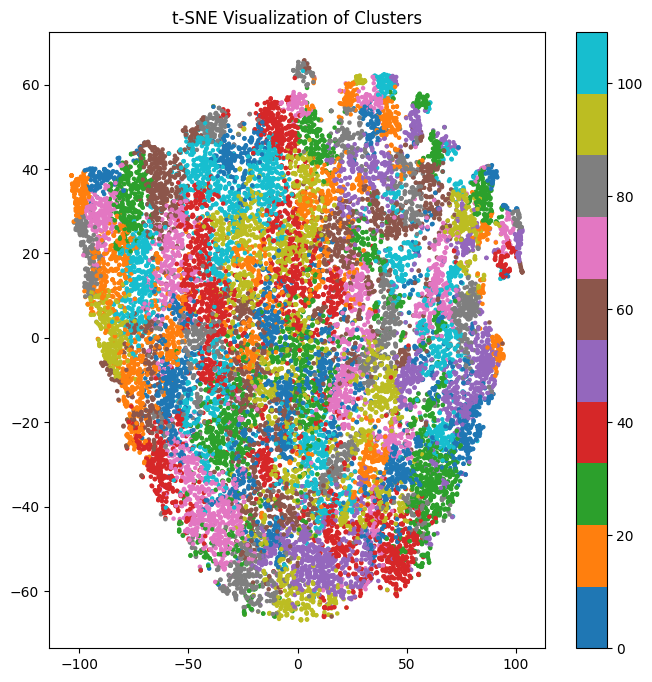

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reducing dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_normalized)

plt.figure(figsize=(8, 8))
plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=labels, cmap='tab10', s=5
)
plt.colorbar()
plt.title("t-SNE Visualization of Clusters")
plt.show()


##Creating output cluster folder

In [ ]:
import shutil

output_folder = "/content/output_clusters"  # Path to save clusters

for label in tqdm(unique_labels, desc="Saving Clusters", unit="cluster"):
    if label == -1:
        continue

    cluster_folder = os.path.join(output_folder, f"cluster_{label}")
    os.makedirs(cluster_folder, exist_ok=True)

    for i, img_path in enumerate(image_paths):
        if labels[i] == label:
            shutil.copy(img_path, cluster_folder)

print("Clustering and saving completed!")


Saving Clusters: 100%|██████████| 110/110 [00:04<00:00, 26.12cluster/s]

Clustering and saving completed!


##Trasferring to Drive

In [ ]:
import shutil

source = "/content/output_clusters"
destination ="/content/drive/MyDrive/mobilenetcluster"

shutil.copytree(source, destination)

'/content/drive/MyDrive/mobilenetcluster'

In [ ]:
import shutil

source_path = "/content/mobilenet_embeddings.pth"
destination_path = "/content/drive/My Drive/mobilenet_embeddings.pth"

shutil.copy(source_path, destination_path)
print(f"File copied to {destination_path}")


File copied to /content/drive/My Drive/mobilenet_embeddings.pth


#B

Doing same here,  creating / extracting embedding from image for query

In [ ]:

def preprocess_image(image_path, device):
    """Preprocess the image for the Re-ID model including noise reduction."""
    img = cv2.imread(image_path)


    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded. Please check the file path.")

    #to redude some blurs/noises
    enhanced_image = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)


    img_resized = cv2.resize(enhanced_image, (128, 256))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    #Normalizing
    img_normalized = img_rgb / 255.0

    # Converting to PyTorch tensor and move to the correct device
    tensor = torch.tensor(img_normalized.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0)
    return tensor.to(device)


def extract_embedding(image_path):
    """Extract feature embedding for a cropped person image."""
    input_tensor = preprocess_image(image_path, device)
    with torch.no_grad():
        embedding = model(input_tensor)
    return embedding.cpu().numpy().flatten()

In [18]:

from tqdm import tqdm
import numpy as np

all_embeddings = []
all_image_paths = []
for image_path in tqdm(image_paths, desc="Extracting Embeddings", unit="image"):
    embedding = extract_embedding(image_path)
    all_embeddings.append(embedding)
    all_image_paths.append(image_path)

# Convert to numpy array for easier comparison
all_embeddings = np.array(all_embeddings)

print(f"Extracted embeddings for {len(all_embeddings)} images.")


Extracting Embeddings: 100%|██████████| 25259/25259 [46:11<00:00,  9.11image/s]


Extracted embeddings for 25259 images.


In [20]:
def extract_query_embedding(query_image_path):
    query_embedding = extract_embedding(query_image_path)  # Extract embedding for the query image
    return query_embedding


In [21]:

def retrieve_similar_images(query_embedding, all_embeddings, all_image_paths, top_n=5):
    """
    Retrieve the top N most similar images to the query image.
    """
    similarities = np.dot(all_embeddings, query_embedding) / (
        np.linalg.norm(all_embeddings, axis=1) * np.linalg.norm(query_embedding)
    )

    top_indices = np.argsort(similarities)[::-1][:top_n]

    similar_images = [(all_image_paths[i], similarities[i]) for i in top_indices]
    return similar_images


In [22]:

def display_images(query_image_path, similar_images):
    """
    Display the query image and the top similar images.
    """
    query_image = cv2.imread(query_image_path)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(similar_images) + 1, 1)
    plt.imshow(query_image)
    plt.axis("off")
    plt.title("Query Image")

    for idx, (image_path, similarity) in enumerate(similar_images):
        similar_image = cv2.imread(image_path)
        similar_image = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(similar_images) + 1, idx + 2)
        plt.imshow(similar_image)
        plt.axis("off")
        plt.title(f"Sim: {similarity:.4f}")

    plt.tight_layout()
    plt.show()




## Code that display image accordng to query, i hope :)

Top 5 similar images for the query image /content/tango-cv-assessment-dataset/0001_c5s2_119224_00.jpg:
1. Image: /content/tango-cv-assessment-dataset/0001_c5s2_119224_00.jpg, Similarity: 1.0000
2. Image: /content/tango-cv-assessment-dataset/1490_c1s6_013121_00.jpg, Similarity: 0.9989
3. Image: /content/tango-cv-assessment-dataset/0442_c5s1_112145_00.jpg, Similarity: 0.9989
4. Image: /content/tango-cv-assessment-dataset/0442_c3s1_111433_00.jpg, Similarity: 0.9989
5. Image: /content/tango-cv-assessment-dataset/0567_c4s3_030779_00.jpg, Similarity: 0.9989


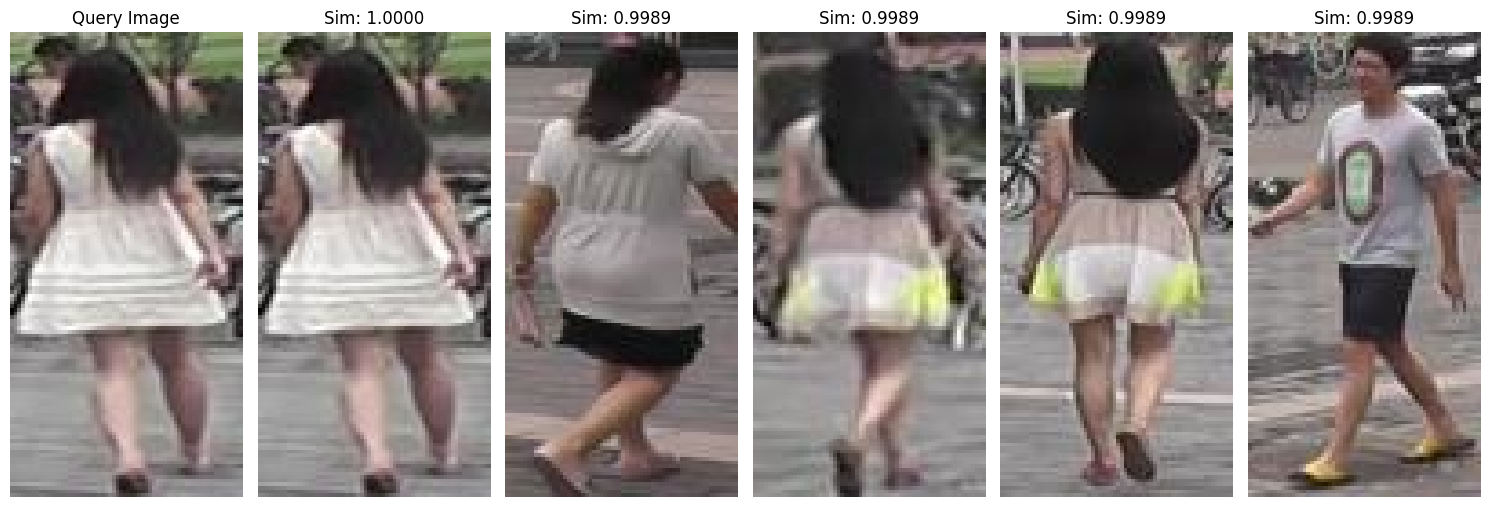

In [23]:

query_image_path = "/content/tango-cv-assessment-dataset/0001_c5s2_119224_00.jpg"  # Replace with the query image path
query_embedding = extract_embedding(query_image_path)  # Use the same function to extract embeddings

similar_images = retrieve_similar_images(query_embedding, all_embeddings, all_image_paths, top_n=5)

print(f"Top 5 similar images for the query image {query_image_path}:")
for idx, (image_path, similarity) in enumerate(similar_images):
    print(f"{idx + 1}. Image: {image_path}, Similarity: {similarity:.4f}")

display_images(query_image_path, similar_images)